# WNTR / EPANET-MSX demo
This demo shows a simple example of multispecies chlorine decay taken from the 
EPANETMSX user manual. The Net3 example network from EPANET is used, and two 
different decay coefficients are assigned - one for each source of water.
The river uses decay coefficient k1, the lake uses decay coefficient k2, and 
the two values are an order of magnitude different. Once the initial example,
from the EPANETMSX user manual, has been run, parameter sensitivity is performed
to look at the impacts of different decay coefficients for the river source.

In [1]:
import matplotlib.pyplot as plt
import wntr
from wntr.msx.elements import InitialQuality
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')
wn.options.quality.parameter = 'NONE'

### Create a new MSX model

In [2]:
wn.add_msx_model()
wn.msx.title = 'Multisource Chlorine Decay'
wn.msx.references.append("""(2023) Shang F, L Rossman, and J Uber. 
"EPANET-MSX 2.0 User Manual". EPA/600/R-22/199""")
wn.msx.options.area_units = 'FT2'
wn.msx.options.rate_units = 'DAY'
wn.msx.options.timestep = 300

### Add the species

In [3]:
# Add the species
wn.msx.add_species('T1','bulk',units='MG', note='Source 1 Tracer')
wn.msx.add_species('CL2','bulk', units='MG', note='Free Chlorine')

Species(name='CL2', species_type=<SpeciesType.BULK: 1>, units='MG', atol=None, rtol=None, note='Free Chlorine')

### Add the coefficients

In [4]:
# Add the constant coefficients
k1 = wn.msx.add_constant('k1', 1.3, units='1/day')
k2 = wn.msx.add_constant('k2', 17.7, units='1/day')
k2

Constant(name='k2', value=17.7, units='1/day')

### Add the recations

In [5]:
# Add the reactions
wn.msx.add_reaction('T1', 'pipe', 'rate', '0')
wn.msx.add_reaction('CL2', 'pipe', 'rate', '-(k1*T1 + k2*(1-T1))*CL2')


Reaction(species_name='CL2', expression_type=<ExpressionType.RATE: 2>, expression='-(k1*T1 + k2*(1-T1))*CL2')

### Set up the initial quality

In [6]:
net_data = wn.msx.network_data
net_data.initial_quality['T1'] = InitialQuality(
    node_values={'River': 1.0}
)
net_data.initial_quality['CL2'] = InitialQuality(
    node_values={'River':1.2, 'Lake':1.2}
)
net_data.initial_quality

{'T1': InitialQuality(global_value=0.0, node_values=<1 entries>, link_values=<0 entries>),
 'CL2': InitialQuality(global_value=0.0, node_values=<2 entries>, link_values=<0 entries>)}

### Run the simulation and view the results

In [7]:
sim = wntr.sim.EpanetSimulator(wn)
res = sim.run_sim()


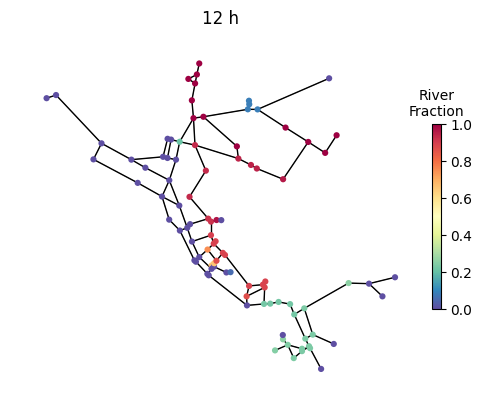

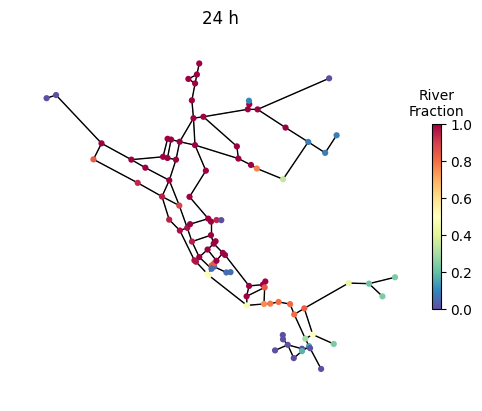

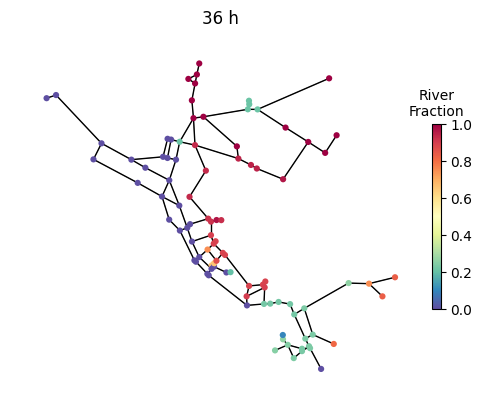

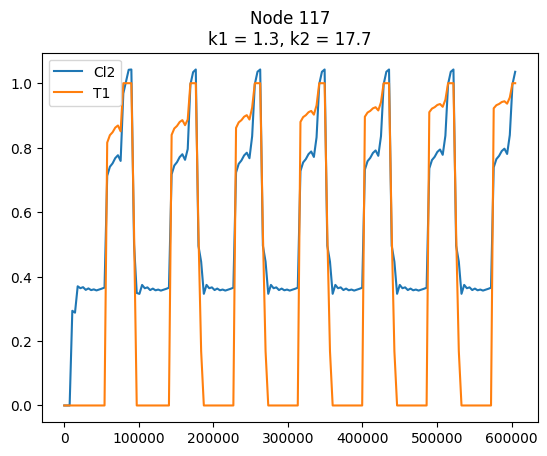

In [8]:
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*12,:], 
    title='12 h', node_colorbar_label='River\nFraction',
)
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*24,:], 
    title='24 h', node_colorbar_label='River\nFraction',
)
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*36,:], 
    title='36 h', node_colorbar_label='River\nFraction',
)
query = '117'  # '191', '269', '117'
res.node['CL2'][query].plot()
res.node['T1'][query].plot()
plt.title('Node {}\nk1 = {:.1f}, k2 = {:.1f}'.format(query, k1.value, k2.value))
_=plt.legend(['Cl2', 'T1'])

### Perform analysis of different k1 values

In [9]:
d_k1 = dict()
for i in range(7):
    # Increase the reaction rate
    newk = 1.3 + (2*i*1.3)
    k1.value = newk
    resk = sim.run_sim()
    d_k1[newk] = resk

Text(0, 0.5, 'River Fraction [/100%]    //    Concentraion [mg/L]')

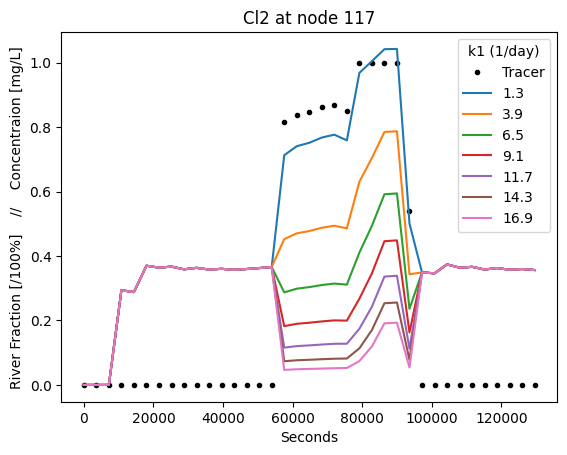

In [10]:
res.node["T1"].loc[0:3600*36, query].plot(style='k.')
for newk, resk in d_k1.items():
    resk.node["CL2"].loc[0:3600*36, query].plot()
plt.legend(['Tracer', *["{:.1f}".format(k) for k in d_k1.keys()]], title="k1 (1/day)")
plt.title("Cl2 at node {}".format(query))
plt.xlabel('Seconds')
plt.ylabel('River Fraction [/100%]    //    Concentraion [mg/L]')